## Initialize the spark environment and load the helper functions we have provided

In [1]:
import sys
sys.path.append('/home/student/ROI/SparkProgram')

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt
#from IPython.display import display

import pyspark_helpers as pyh
sc, spark, conf = pyh.initspark()
from pyspark_helpers import display

initializing pyspark
pyspark initialized


## Read in a simple dataset of latitudes and longitudes

In [3]:
filename = 'superchargers.csv'
df = spark.read.csv(f'/home/student/ROI/Spark/{filename}', header = True, inferSchema = True)
display(df)

# Save a pointer to the raw data
dfRawFile = df



,lat,lng
0,33.679646,-117.174095
1,28.331356,-81.532453
2,37.413353,-121.897995
3,37.525905,-122.006624
4,37.919969,-122.348976
5,38.730606,-120.788085
6,39.250765,-119.948927
7,36.916349,-121.773512
8,34.441994,-119.258898
9,36.116710,-115.168258


## Visualize this dataset using pandas
Normally you don't do this in spark but it is helpful here

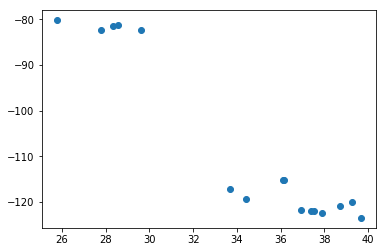

In [7]:
%matplotlib inline
p = df.toPandas()
import matplotlib.pyplot as plt
plt.plot(p.loc[:,'lat'],p.loc[:,'lng'],'o')



## Turn the features into a big vector

In [20]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["lat", "lng"], outputCol="features")
dfML = vecAssembler.transform(df)
display(dfML)


,lat,lng,features
0,33.679646,-117.174095,"[33.679646, -117.174095]"
1,28.331356,-81.532453,"[28.331356, -81.532453]"
2,37.413353,-121.897995,"[37.413353, -121.897995]"
3,37.525905,-122.006624,"[37.525905, -122.006624]"
4,37.919969,-122.348976,"[37.919969, -122.348976]"
5,38.730606,-120.788085,"[38.730606, -120.788085]"
6,39.250765,-119.948927,"[39.250765, -119.948927]"
7,36.916349,-121.773512,"[36.916349, -121.773512]"
8,34.441994,-119.258898,"[34.441994, -119.258898]"
9,36.116710,-115.168258,"[36.11671, -115.168258]"


## Load the KMeans class and train the model
Evaluate how good it performs for several different cluster counts

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def evaluateCluster(model, df):
    wssse = model.computeCost(dfML.select('features'))
    print("Within Set Sum of Squared Errors = " + str(wssse))

    evaluator = ClusteringEvaluator()

    predictions = model.transform(df)
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

for k in range(2, 5):
    print ('Number of clusters', k)
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dfML.select('features'))
    evaluateCluster(model, dfML.select('features'))
    print()


Number of clusters 2
Within Set Sum of Squared Errors = 129.99096466421906
Silhouette with squared euclidean distance = 0.987806408922707
Cluster Centers: 
[ 28.0131932 -81.5283882]
[  37.07758755 -119.92139927]

Number of clusters 3
Within Set Sum of Squared Errors = 41.11022514378055
Silhouette with squared euclidean distance = 0.8702679015072282
Cluster Centers: 
[  38.20660229 -121.74965171]
[  35.10181175 -116.7219575 ]
[ 28.0131932 -81.5283882]

Number of clusters 4
Within Set Sum of Squared Errors = 35.03850353437156
Silhouette with squared euclidean distance = 0.7646576235092908
Cluster Centers: 
[ 28.0131932 -81.5283882]
[  37.95949117 -121.4606865 ]
[  35.10181175 -116.7219575 ]
[  39.689269 -123.483443]



## Visualize the cluster results graphically

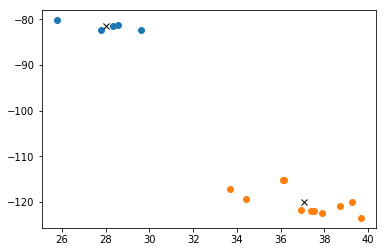

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

CLUSTERS = 2
kmeans = KMeans().setK(CLUSTERS).setSeed(1)
model = kmeans.fit(dfML.select('features'))
predictions = model.transform(dfML)
centroids = model.clusterCenters()

for i in range(CLUSTERS):    
    p = predictions.select('lat', 'lng').where(f'prediction = {i}').toPandas()
    plt.plot(p.loc[:,'lat'],p.loc[:,'lng'],'o')
    plt.plot(centroids[i][0], 
           centroids[i][1],'kx')


## Use and elbow chart to help visualize what is the optimal number of clusters

[129.99096466421906, 41.11022514378055, 35.03850353437156, 20.778402640553395]


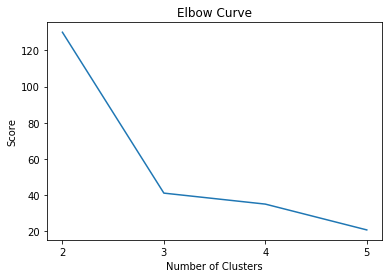

In [23]:
%matplotlib inline
def plot_elbow(df, cluster_cnt = 6):
    import numpy as np
    CLUSTERS = range(2, cluster_cnt)
    scores = [KMeans().setK(c).setSeed(1).fit(df).computeCost(df)
              for c in CLUSTERS]
    print(scores)
    plt.plot(CLUSTERS, scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.xticks(np.arange(2, cluster_cnt))

plot_elbow(dfML.select('features'))

## Work in progress below

In [ ]:
from pyspark.ml.clustering import LDA
lda = LDA(k=10, maxIter=10)
model = lda.fit(dfML.select('features'))

ll = model.logLikelihood(dfML)
lp = model.logPerplexity(dfML)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(dataset.select('features'))
transformed.show()

In [6]:
from pyspark.ml.clustering import GaussianMixture

# loads data
gmm = GaussianMixture().setK(2).setSeed(1)
model = gmm.fit(dfML.select('features'))

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+----------------------------------------+-------------------------------------------------------------------------------------+
|mean                                    |cov                                                                                  |
+----------------------------------------+-------------------------------------------------------------------------------------+
|[37.077587545454506,-119.92139927272711]|3.2333405356350844  -3.090935456661164  
-3.090935456661164  7.552645474238561       |
|[28.01319320000047,-81.52838820000206]  |1.6190592360003555   -0.8028581428508544  
-0.8028581428508544  0.6499644752140439   |
+----------------------------------------+-------------------------------------------------------------------------------------+

